In [246]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math

In [247]:
def checkOutlier(df: pd.DataFrame, graph='BV', showIQR=True) -> None:
    columns = df.columns
    n_cols = 2
    n_rows = math.ceil(len(columns) / n_cols)
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 6 * n_rows))
    axes = axes.flatten()
    
    title_fontsize = 15
    label_fontsize = 10
    tick_fontsize = 10

    for idx, column in enumerate(columns):
        if graph == 'BV':
            axes[idx].boxplot(df[column].dropna(), vert=False, showmeans=True)
            axes[idx].violinplot(df[column].dropna(), vert=False, showextrema=False)
            axes[idx].grid()
            axes[idx].set_ylabel(column, fontsize=label_fontsize)
        elif graph == 'Hist':
            if df[column].dtype in [pd.Int64Dtype(), pd.Int32Dtype()]:
                df_hist = df[column].dropna().value_counts().sort_index()
                axes[idx].bar(df_hist.index, df_hist.values, edgecolor='black')
                axes[idx].set_xticks(np.arange(df[column].min(), df[column].max() + 1, 1))
                axes[idx].set_xlabel(column, fontsize=label_fontsize)
            elif pd.api.types.is_categorical_dtype(df[column]) or df[column].dtype == 'O':
                value_counts = df[column].value_counts()
                axes[idx].bar(value_counts.index, value_counts.values, edgecolor='black')
                axes[idx].set_xticklabels(value_counts.index, rotation=90, ha='right')
                axes[idx].set_xlabel(column, fontsize=label_fontsize)
        axes[idx].set_title(column, fontsize=title_fontsize)
        axes[idx].tick_params(axis='both', which='major', labelsize=tick_fontsize)

    # Hide any unused subplots
    for idx in range(len(columns), len(axes)):
        fig.delaxes(axes[idx])
    
    plt.tight_layout()
    plt.show()
    
    if showIQR:
        for column in columns:
            print(f"Statistics for {column}:")
            show_quartile(df[column].dropna())
            print()

def show_quartile(series: pd.Series) -> None:
    q1, mean, q3 = np.percentile(series, [25, 50, 75])
    iqr = q3 - q1
    print('Q1: {}'.format(q1))
    print('Median: {}'.format(mean))
    print('Q3: {}'.format(q3))
    print('IQR: {}'.format(iqr))
    upper = q3 + (1.5 * iqr)
    lower = q1 - (1.5 * iqr)
    print('Lower: {:.2f} \nUpper: {:.2f}'.format(lower, upper))



## House data

#### 1. Load ข้อมูลและทำความเข้าใจข้อมูล

In [248]:
df_house = pd.read_csv('data\house_data.csv')

In [249]:
display(df_house.head(3))
print(df_house.shape)
print(df_house.info())

,Suburb,Address,Lattitude,Longtitude,Distance,Type,Rooms,Bedroom2,Bathroom,Landsize
0,Abbotsford,85 Turner St,-37.7996,144.9984,2.5,h,2,2.0,1.0,202.0
1,Abbotsford,25 Bloomburg St,-37.8079,144.9934,2.5,h,2,2.0,1.0,156.0
2,Abbotsford,5 Charles St,-37.8093,144.9944,2.5,h,3,3.0,2.0,134.0


(13512, 10)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13512 entries, 0 to 13511
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Suburb      13512 non-null  object 
 1   Address     13512 non-null  object 
 2   Lattitude   13512 non-null  float64
 3   Longtitude  13512 non-null  float64
 4   Distance    13512 non-null  float64
 5   Type        13512 non-null  object 
 6   Rooms       13512 non-null  int64  
 7   Bedroom2    13512 non-null  float64
 8   Bathroom    13512 non-null  float64
 9   Landsize    13512 non-null  float64
dtypes: float64(6), int64(1), object(3)
memory usage: 1.0+ MB
None


In [250]:
df_house.rename(columns={'Bedroom2':'Bedroom'}, inplace=True)

#### 2. สำรวจ Missing values

In [251]:
df_house.isnull().sum()

Suburb        0
Address       0
Lattitude     0
Longtitude    0
Distance      0
Type          0
Rooms         0
Bedroom       0
Bathroom      0
Landsize      0
dtype: int64

In [252]:
df_house.isnull().sum().sum()

0

#### 3. เปลี่ยนชนิดข้อมูลให้เหมาะสม

In [253]:
#Change dtype's Type from string to category
df_house['Type'] = df_house['Type'].astype('category')

In [254]:
df_house['Rooms'] = df_house['Rooms'].astype(pd.Int64Dtype())

In [255]:
#Check Bedroom2 is all interger not float
check_not_float = df_house['Bedroom'].apply(lambda x: True if (x.is_integer()) or np.isnan(x) else False)
print(check_not_float.all())

if check_not_float.all():
    #Change dtype's Bedroom2 from float to int
    df_house['Bedroom'] = df_house['Bedroom'].astype(pd.Int64Dtype())

True


In [256]:
#Check Bathroom is all interger not float    
check_not_float = df_house['Bathroom'].apply(lambda x: True if (x.is_integer()) or np.isnan(x) else False)
print(check_not_float.all())

if check_not_float.all():
    #Change dtype's Bathroom from float to int
    df_house['Bathroom'] = df_house['Bathroom'].astype(pd.Int64Dtype())

True


In [257]:
df_house.dtypes

Suburb          object
Address         object
Lattitude      float64
Longtitude     float64
Distance       float64
Type          category
Rooms            Int64
Bedroom          Int64
Bathroom         Int64
Landsize       float64
dtype: object

#### 4. สำรวจข้อมูลว่า อยู่ในรูปแบบที่ถูกต้องเหมาะสม

In [258]:
#check some Address, CouncilArea and SellerG is not invalid(numerical) form
check_not_number = df_house[['Suburb','Address']].map(lambda x: not str.isnumeric(x) if isinstance(x, str) else True if np.isnan(x) else False)
check_not_number.all().all()
# check_not_number

True

In [259]:
#Make upper to every column that dtype is string to check duplicate
for col in df_house.select_dtypes(include='object').columns:
    df_house[col] = df_house[col].str.upper()

display(df_house.sample(2))

,Suburb,Address,Lattitude,Longtitude,Distance,Type,Rooms,Bedroom,Bathroom,Landsize
11697,NOBLE PARK,371 PRINCES HWY,-37.96318,145.18962,22.7,h,3,3,1,603.0
13413,MALVERN,7 NORTHBROOK AV,-37.85612,145.03273,5.9,h,4,4,2,633.0


In [260]:
#check numerical column store values that not minus numbers *except cordinate values
check_not_minus = df_house.select_dtypes(['int64', 'float64']).map(lambda x:True if x<0 else False)
check_not_minus.any()

Lattitude      True
Longtitude    False
Distance      False
Rooms         False
Bedroom       False
Bathroom      False
Landsize      False
dtype: bool

#### 5. ตรวจสอบ Missing values อีกครั้ง

In [261]:
df_house.isnull().sum()

Suburb        0
Address       0
Lattitude     0
Longtitude    0
Distance      0
Type          0
Rooms         0
Bedroom       0
Bathroom      0
Landsize      0
dtype: int64

In [262]:
df_house.isnull().sum().sum()

0

#### 6. ตรวจสอบข้อมูลซ้ำ

In [263]:
check_duplicate = df_house.duplicated(keep=False)
check_duplicate.any()

True

In [264]:
df_house[check_duplicate]

,Suburb,Address,Lattitude,Longtitude,Distance,Type,Rooms,Bedroom,Bathroom,Landsize
625,BALWYN NORTH,23A THE BOULEVARD,-37.7868,145.0677,9.2,h,5,5,3,900.0
677,BALWYN NORTH,23A THE BOULEVARD,-37.7868,145.0677,9.2,h,5,5,3,900.0


#### 7. สำรวจสถิติเบื้องต้น

In [265]:
df_house.describe().iloc[:,2:]

,Distance,Rooms,Bedroom,Bathroom,Landsize
count,13512.000000,13512.0,13512.0,13512.0,13512.000000
mean,10.147321,2.938499,2.915187,1.533822,559.374926
std,5.871053,0.955446,0.965653,0.691605,4000.590761
min,0.000000,1.0,0.0,0.0,0.000000
25%,6.175000,2.0,2.0,1.0,177.000000
50%,9.200000,3.0,3.0,1.0,441.000000
75%,13.000000,3.0,3.0,2.0,651.000000
max,48.100000,10.0,20.0,8.0,433014.000000


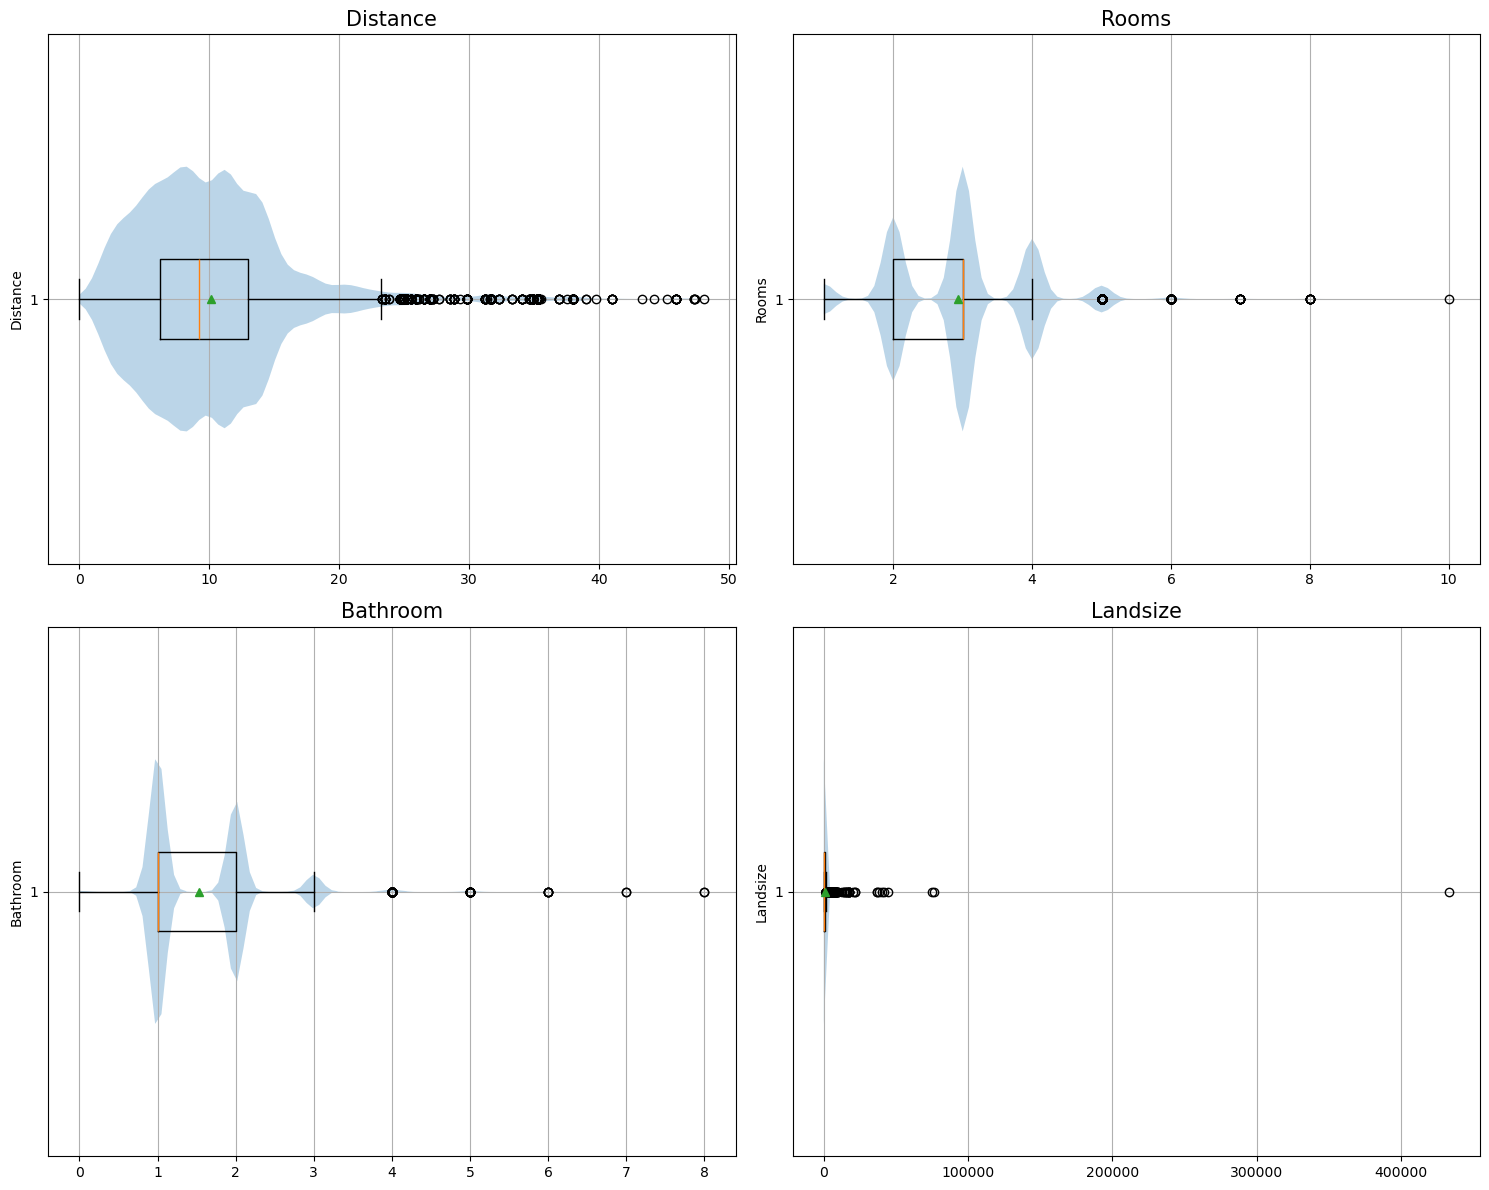

Statistics for Distance:
Q1: 6.175
Median: 9.2
Q3: 13.0
IQR: 6.825
Lower: -4.06 
Upper: 23.24

Statistics for Rooms:
Q1: 2.0
Median: 3.0
Q3: 3.0
IQR: 1.0
Lower: 0.50 
Upper: 4.50

Statistics for Bathroom:
Q1: 1.0
Median: 1.0
Q3: 2.0
IQR: 1.0
Lower: -0.50 
Upper: 3.50

Statistics for Landsize:
Q1: 177.0
Median: 441.0
Q3: 651.0
IQR: 474.0
Lower: -534.00 
Upper: 1362.00



In [266]:
checkOutlier(df_house[['Distance', 'Rooms', 'Bathroom', 'Landsize']])

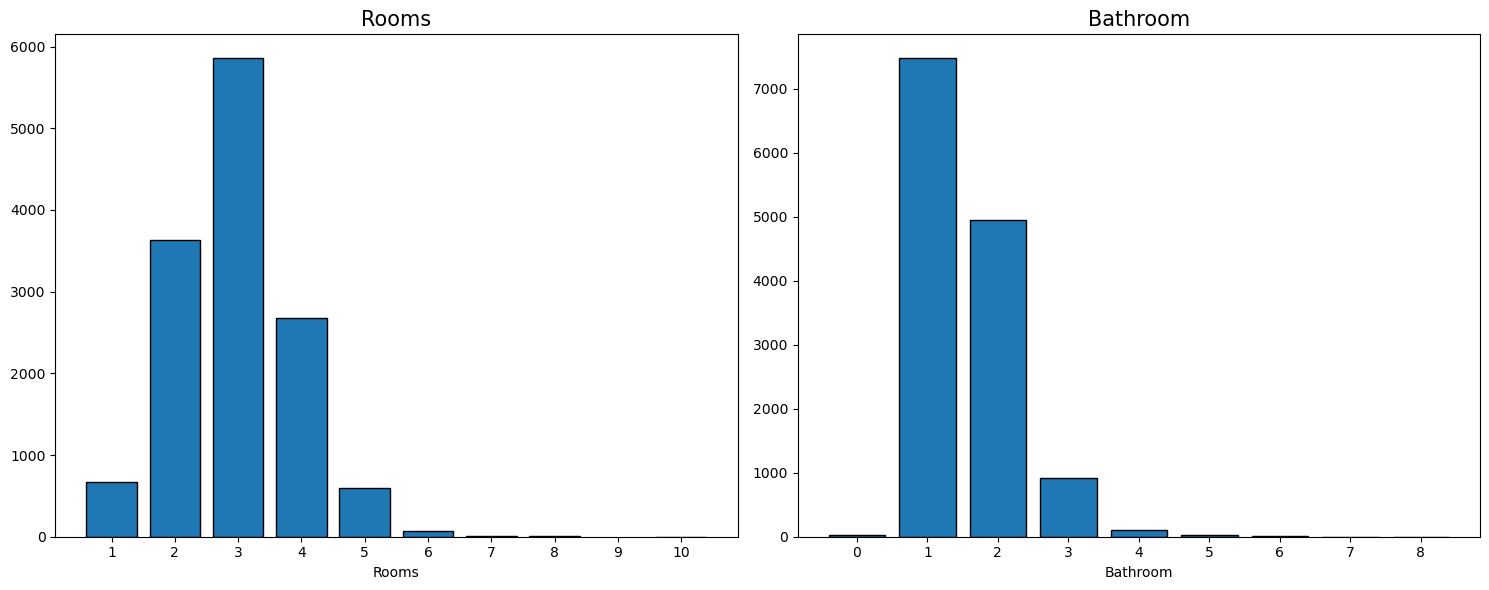

In [267]:
checkOutlier(df_house[['Rooms', 'Bathroom']], graph='Hist', showIQR=False)

#### 8. ตรวจหาค่า Outlier

## Sale data

#### 1. Load ข้อมูลและทำความเข้าใจข้อมูล

In [268]:
df_sale = pd.read_csv('data\sale_data.csv')

In [269]:
display(df_sale.head(3))
print(df_sale.shape)
print(df_sale.info())

,sale_no,Address,CouncilArea,YearBuilt,BuildingArea,Car,Price,Date,Method,SellerG
0,1,85 Turner St,Yarra,NaN,NaN,1.0,1480000.0,3/12/2016,S,Biggin
1,2,25 Bloomburg St,Yarra,1900.0,79.0,0.0,1035000.0,4/02/2016,S,Biggin
2,3,5 Charles St,Yarra,1900.0,150.0,0.0,1465000.0,4/03/2017,SP,Biggin


(13580, 10)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13580 entries, 0 to 13579
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   sale_no       13580 non-null  int64  
 1   Address       13580 non-null  object 
 2   CouncilArea   12211 non-null  object 
 3   YearBuilt     8205 non-null   float64
 4   BuildingArea  7130 non-null   float64
 5   Car           13518 non-null  float64
 6   Price         13580 non-null  float64
 7   Date          13580 non-null  object 
 8   Method        13580 non-null  object 
 9   SellerG       13580 non-null  object 
dtypes: float64(4), int64(1), object(5)
memory usage: 1.0+ MB
None


#### 2. สำรวจ Missing values

In [270]:
df_sale.isnull().sum()

sale_no            0
Address            0
CouncilArea     1369
YearBuilt       5375
BuildingArea    6450
Car               62
Price              0
Date               0
Method             0
SellerG            0
dtype: int64

In [271]:
df_sale.isnull().sum().sum()

13256

#### 3. เปลี่ยนชนิดข้อมูลให้เหมาะสม

In [272]:
#Change dtype's sale_no from float to string
df_sale['sale_no'] = df_sale["sale_no"].astype(str)

In [273]:
#Check YearBuilt is all interger not float    
check_not_float = df_sale['YearBuilt'].apply(lambda x: True if (x.is_integer()) or np.isnan(x) else False)
print(check_not_float.all())

if check_not_float.all():
    #Change dtype's YearBuilt from float to int
    df_sale['YearBuilt'] = df_sale['YearBuilt'].astype(pd.Int64Dtype())

True


In [274]:
#Check Car is all interger not float    
check_not_float = df_sale['Car'].apply(lambda x: True if (x.is_integer()) or np.isnan(x) else False)
print(check_not_float.all())

if check_not_float.all():
    #Change dtype's Car from float to int
    df_sale['Car'] = df_sale['Car'].astype(pd.Int64Dtype())

True


In [275]:
#Change dtype's Date from string to datetime
df_sale['Date'] = pd.to_datetime(df_sale['Date'], dayfirst=True)

In [276]:
#Change dtype's Method from string to category
df_sale['Method'] = df_sale['Method'].astype('category')

In [277]:
df_sale.dtypes

sale_no                 object
Address                 object
CouncilArea             object
YearBuilt                Int64
BuildingArea           float64
Car                      Int64
Price                  float64
Date            datetime64[ns]
Method                category
SellerG                 object
dtype: object

#### 4. สำรวจข้อมูลว่า อยู่ในรูปแบบที่ถูกต้องเหมาะสม

In [278]:
#check some Address, CouncilArea and SellerG is not invalid(numerical) form
check_not_number = df_sale[['Address','CouncilArea','SellerG']].map(lambda x: not str.isnumeric(x) if isinstance(x, str) else True if np.isnan(x) else False)
check_not_number.all().all()
# check_not_number

True

In [279]:
#Make upper to every column that dtype is string to check duplicate
for col in df_sale.select_dtypes(include='object').columns:
    df_sale[col] = df_sale[col].str.upper()

display(df_sale.sample(2))

,sale_no,Address,CouncilArea,YearBuilt,BuildingArea,Car,Price,Date,Method,SellerG
4586,4587,66 FITZGIBBON ST,MELBOURNE,1900,NaN,1,1851000.0,2016-08-22,S,MARSHALL
3040,3041,50 EARLSFIELD RD,BAYSIDE,<NA>,NaN,2,1460000.0,2016-12-10,SP,BUXTON


In [280]:
#check numerical column store values that not minus numbers
check_not_minus = df_sale.select_dtypes(['int64', 'float64']).map(lambda x:True if x<0 else False)
check_not_minus.any()

YearBuilt       False
BuildingArea    False
Car             False
Price           False
dtype: bool

#### 5. ตรวจสอบ Missing values อีกครั้ง

In [281]:
df_sale.isnull().sum()

sale_no            0
Address            0
CouncilArea     1369
YearBuilt       5375
BuildingArea    6450
Car               62
Price              0
Date               0
Method             0
SellerG            0
dtype: int64

In [282]:
df_sale.isnull().sum().sum()

13256

#### 6. ตรวจสอบข้อมูลซ้ำ

In [283]:
#check duplicated values
print(df_sale.duplicated(['sale_no']).any())

False


In [284]:
#check that 1 sale_no that have 1 Address
#Because 1 sale_no can have 1 Address, and 1 Address can have only 1 sale_no
fil = (df_sale.groupby('sale_no')['Address'].nunique()>1)
fil = fil[fil == True]
df_sale[df_sale['sale_no'].isin(fil.index)].sort_values(['sale_no','Address'])

,sale_no,Address,CouncilArea,YearBuilt,BuildingArea,Car,Price,Date,Method,SellerG


#### 7. สำรวจสถิติเบื้องต้น

In [285]:
df_sale.describe().iloc[:,:-1]

,YearBuilt,BuildingArea,Car,Price
count,8205.0,7130.000000,13518.0,1.358000e+04
mean,1964.684217,151.967650,1.610075,1.075684e+06
min,1196.0,0.000000,0.0,8.500000e+04
25%,1940.0,93.000000,1.0,6.500000e+05
50%,1970.0,126.000000,2.0,9.030000e+05
75%,1999.0,174.000000,2.0,1.330000e+06
max,2018.0,44515.000000,10.0,9.000000e+06
std,37.273762,541.014538,0.962634,6.393107e+05


#### 8. ตรวจหาค่า Outlier

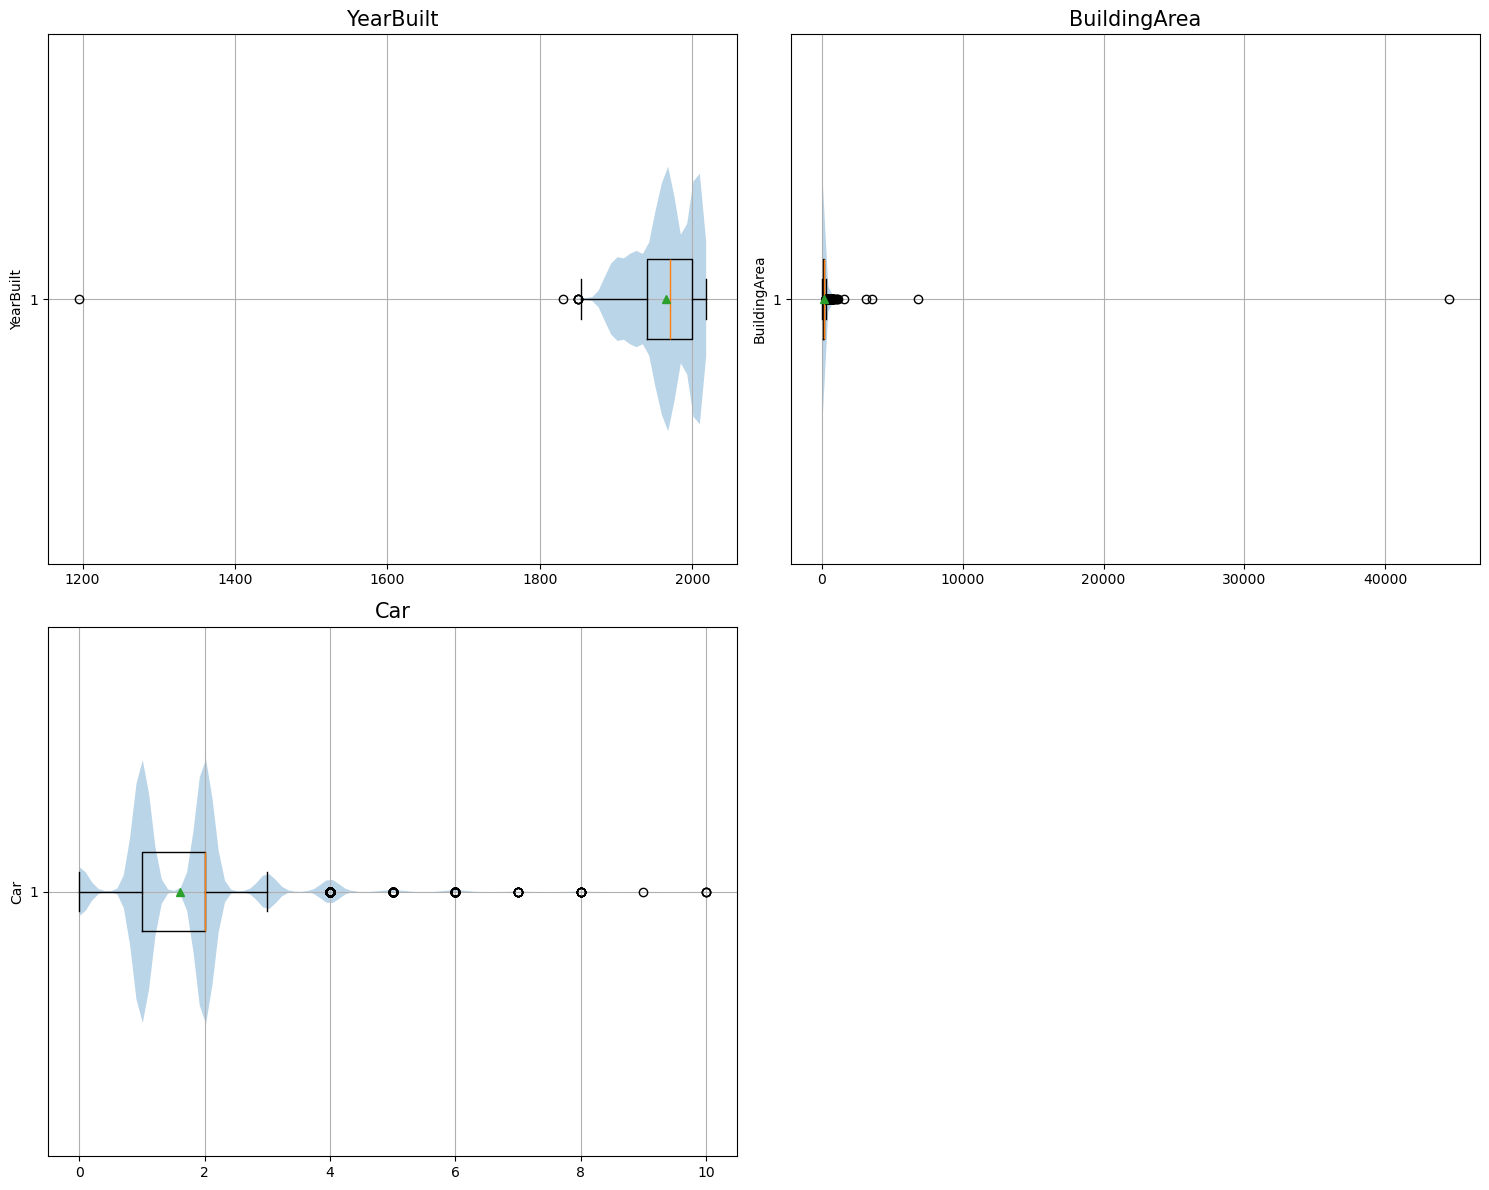

Statistics for YearBuilt:
Q1: 1940.0
Median: 1970.0
Q3: 1999.0
IQR: 59.0
Lower: 1851.50 
Upper: 2087.50

Statistics for BuildingArea:
Q1: 93.0
Median: 126.0
Q3: 174.0
IQR: 81.0
Lower: -28.50 
Upper: 295.50

Statistics for Car:
Q1: 1.0
Median: 2.0
Q3: 2.0
IQR: 1.0
Lower: -0.50 
Upper: 3.50



In [286]:
checkOutlier(df_sale[['YearBuilt','BuildingArea','Car']])

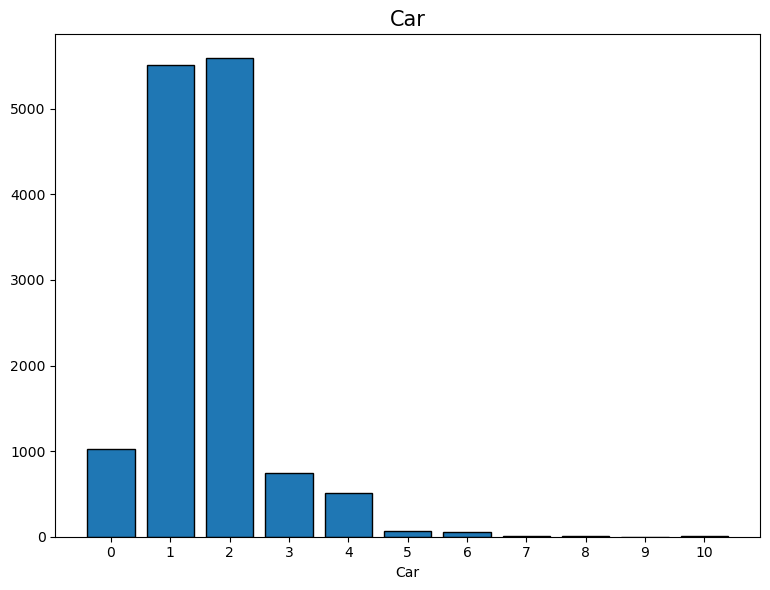

Statistics for Car:
Q1: 1.0
Median: 2.0
Q3: 2.0
IQR: 1.0
Lower: -0.50 
Upper: 3.50



In [287]:
checkOutlier(df_sale[['Car']], graph='Hist', showIQR=True)

## Suburb data

#### 1. Load ข้อมูลและทำความเข้าใจข้อมูล

In [288]:
df_suburb = pd.read_csv('data\Suburb_data.csv')

In [289]:
display(df_suburb.sample(5))
print(df_suburb.shape)
print(df_suburb.info())

,Suburb,Regionname,Postcode,Propertycount
114,Carlton,Northern Metropolitan,3053.0,6786.0
107,Yallambie,Northern Metropolitan,3085.0,1369.0
243,Seabrook,Western Metropolitan,3028.0,1793.0
181,Keysborough,South-Eastern Metropolitan,3173.0,8459.0
54,Heidelberg Heights,Eastern Metropolitan,3081.0,2947.0


(314, 4)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 314 entries, 0 to 313
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Suburb         314 non-null    object 
 1   Regionname     314 non-null    object 
 2   Postcode       314 non-null    float64
 3   Propertycount  314 non-null    float64
dtypes: float64(2), object(2)
memory usage: 9.9+ KB
None


#### 2. สำรวจ Missing values

In [290]:
df_suburb.isnull().sum().sum()

0

#### 3. เปลี่ยนชนิดข้อมูลให้เหมาะสม

In [291]:
#Check Postcode is all interger not float    
check_not_float = df_suburb['Postcode'].apply(lambda x: True if (x.is_integer()) or np.isnan(x) else False)
print(check_not_float.all())

if check_not_float.all():
    #Change dtype's Propertycount from float to int
    df_suburb['Postcode'] = pd.to_numeric(df_suburb['Postcode'], errors='coerce', downcast='integer')

    #Change dtype's postcode from float to category
    df_suburb['Postcode'] = df_suburb["Postcode"].astype('category')

True


In [292]:
#Check Propertycount is all interger not float   
check_not_float = df_suburb['Propertycount'].apply(lambda x: True if (x.is_integer()) or np.isnan(x) else False)
print(check_not_float.all())

if check_not_float.all():
    #Change dtype's Propertycount from float to int
    df_suburb['Propertycount'] = df_suburb['Propertycount'].astype(int)

True


In [293]:
df_suburb.dtypes

Suburb             object
Regionname         object
Postcode         category
Propertycount       int32
dtype: object

#### 4. สำรวจข้อมูลว่า อยู่ในรูปแบบที่ถูกต้องเหมาะสม

In [294]:
#check some Suburb and Regionname is not invalid(numerical) form
check_not_number = df_suburb[['Suburb','Regionname']].map(lambda x: not str.isnumeric(x))
check_not_number.all().all()

True

In [295]:
#Make upper to every column that dtype is string to check duplicate records
for col in df_suburb.select_dtypes(include='object').columns:
    df_suburb[col] = df_suburb[col].str.upper()

display(df_suburb.sample(2))

,Suburb,Regionname,Postcode,Propertycount
41,ESSENDON NORTH,WESTERN METROPOLITAN,3041,1308
174,HALLAM,SOUTH-EASTERN METROPOLITAN,3803,3728


In [296]:
#check numerical column store values that not minus numbers
check_not_minus = df_suburb.select_dtypes(['int16']).map(lambda x:True if x<0 else False)
check_not_minus.any()


Series([], dtype: bool)

#### 5. ตรวจสอบ Missing values อีกครั้ง

In [297]:
df_suburb.isnull().sum().sum()

0

In [298]:
#check that 1 postcode that have more than 1 Suburb area 
#Because 1 postcode can have many Suburb, but 1 Suburb can have only 1 postcode
fil = (df_suburb.groupby('Postcode')['Regionname'].nunique()>1)
fil = fil[fil == True]
df_suburb[df_suburb['Postcode'].isin(fil.index)].sort_values(['Postcode','Suburb'])

C:\Users\gotxz\AppData\Local\Temp\ipykernel_8840\3329404558.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  fil = (df_suburb.groupby('Postcode')['Regionname'].nunique()>1)


,Suburb,Regionname,Postcode,Propertycount
147,BRIAR HILL,EASTERN METROPOLITAN,3088,1390
173,GREENSBOROUGH,NORTHERN METROPOLITAN,3088,8524
283,ST HELENA,EASTERN METROPOLITAN,3088,915
70,MONT ALBERT,EASTERN METROPOLITAN,3127,2079
97,SURREY HILLS,SOUTHERN METROPOLITAN,3127,5457
231,GLEN WAVERLEY,EASTERN METROPOLITAN,3150,15321
248,WHEELERS HILL,SOUTH-EASTERN METROPOLITAN,3150,7392
228,CLAYTON,SOUTH-EASTERN METROPOLITAN,3168,5837
256,NOTTING HILL,SOUTHERN METROPOLITAN,3168,902
296,KURUNJANG,NORTHERN VICTORIA,3337,3553


#### 6. ตรวจสอบข้อมูลซ้ำ

In [299]:
#check duplicated values
print(df_suburb.duplicated(['Suburb', 'Regionname']).any())

False


#### 7. สำรวจสถิติเบื้องต้น

In [300]:
df_suburb.describe()

,Propertycount
count,314.000000
mean,5034.063694
std,3800.740940
min,249.000000
25%,2329.750000
50%,3964.000000
75%,6910.000000
max,21650.000000


#### 8. ตรวจหาค่า Outlier

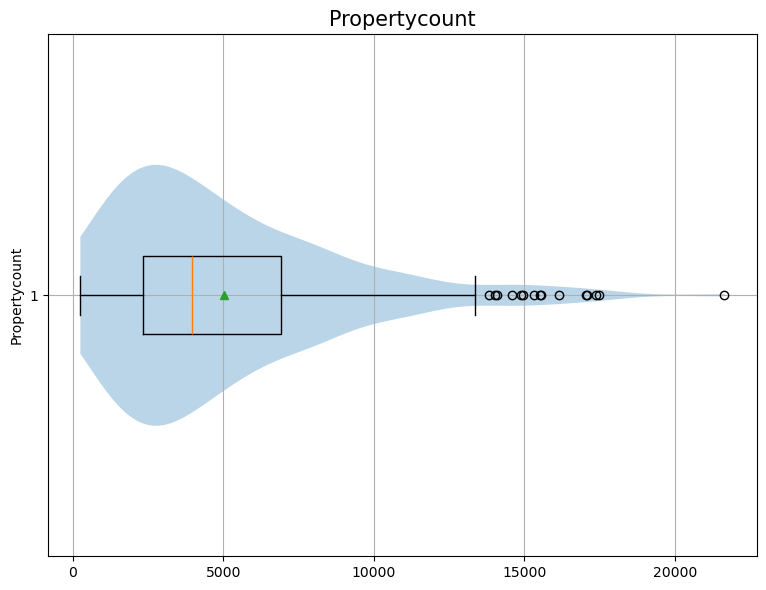

Statistics for Propertycount:
Q1: 2329.75
Median: 3964.0
Q3: 6910.0
IQR: 4580.25
Lower: -4540.62 
Upper: 13780.38



In [301]:
checkOutlier(df_suburb[['Propertycount']])


## Merge data

#### 1. Load ข้อมูลและทำความเข้าใจข้อมูล

In [302]:
df_merge = pd.merge(df_sale, df_house, how='left', on='Address')
df_merge = pd.merge(df_merge, df_suburb, how='left', on='Suburb')


In [303]:
df =df_merge.copy()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13868 entries, 0 to 13867
Data columns (total 22 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   sale_no        13868 non-null  object        
 1   Address        13868 non-null  object        
 2   CouncilArea    12473 non-null  object        
 3   YearBuilt      8384 non-null   Int64         
 4   BuildingArea   7294 non-null   float64       
 5   Car            13804 non-null  Int64         
 6   Price          13868 non-null  float64       
 7   Date           13868 non-null  datetime64[ns]
 8   Method         13868 non-null  category      
 9   SellerG        13868 non-null  object        
 10  Suburb         13868 non-null  object        
 11  Lattitude      13868 non-null  float64       
 12  Longtitude     13868 non-null  float64       
 13  Distance       13868 non-null  float64       
 14  Type           13868 non-null  category      
 15  Rooms          1386

In [304]:
df.head(5)

,sale_no,Address,CouncilArea,YearBuilt,BuildingArea,Car,Price,Date,Method,SellerG,...,Longtitude,Distance,Type,Rooms,Bedroom,Bathroom,Landsize,Regionname,Postcode,Propertycount
0,1,85 TURNER ST,YARRA,<NA>,NaN,1,1480000.0,2016-12-03,S,BIGGIN,...,144.9984,2.5,h,2,2,1,202.0,NORTHERN METROPOLITAN,3067,4019
1,2,25 BLOOMBURG ST,YARRA,1900,79.0,0,1035000.0,2016-02-04,S,BIGGIN,...,144.9934,2.5,h,2,2,1,156.0,NORTHERN METROPOLITAN,3067,4019
2,3,5 CHARLES ST,YARRA,1900,150.0,0,1465000.0,2017-03-04,SP,BIGGIN,...,144.9944,2.5,h,3,3,2,134.0,NORTHERN METROPOLITAN,3067,4019
3,3,5 CHARLES ST,YARRA,1900,150.0,0,1465000.0,2017-03-04,SP,BIGGIN,...,145.0916,9.2,h,4,4,2,659.0,SOUTHERN METROPOLITAN,3146,10412
4,3,5 CHARLES ST,YARRA,1900,150.0,0,1465000.0,2017-03-04,SP,BIGGIN,...,144.8329,13.3,h,4,4,2,570.0,WESTERN METROPOLITAN,3020,4217


#### 2. สำรวจ Missing values

In [305]:
df.isnull().sum()

sale_no             0
Address             0
CouncilArea      1395
YearBuilt        5484
BuildingArea     6574
Car                64
Price               0
Date                0
Method              0
SellerG             0
Suburb              0
Lattitude           0
Longtitude          0
Distance            0
Type                0
Rooms               0
Bedroom             0
Bathroom            0
Landsize            0
Regionname          0
Postcode            0
Propertycount       0
dtype: int64

In [306]:
#Calculate NaN value
missing_count = df.isnull().sum()

total_cells = np.product(df.shape)
total_missing = missing_count.sum()

missing_percent = total_missing *100 /total_cells

print('Total cells: {}' . format(total_cells))
print('Total missing values: {}' . format(total_missing))
print('missing: {} %' . format(missing_percent))

Total cells: 305096
Total missing values: 13517
missing: 4.430408789364659 %


In [307]:
#Calculate NaN record
missing_count_records = df.isnull().any(axis=1)

total_records = df.shape[0]
total_missing_records = missing_count_records.sum()

missing_percent_records = total_missing_records *100 /total_records

print('Total records: {}' . format(total_records))
print('Total missing values: {}' . format(total_missing_records))
print('missing: {} %' . format(missing_percent_records))


Total records: 13868
Total missing values: 7530
missing: 54.29766368618402 %


#### 3. เปลี่ยนชนิดข้อมูลให้เหมาะสม

In [308]:
#all done

#### 4. สำรวจข้อมูลว่า อยู่ในรูปแบบที่ถูกต้องเหมาะสม

#### 5. ตรวจสอบ Missing values อีกครั้ง

In [309]:
#replace Lansize which is 0 with mean of Landsize area
check_not_zero = df[(df['Landsize'] > 0)]
check_not_zero = check_not_zero['Landsize']
print(check_not_zero.size)

Land_size_mean = check_not_zero.mean()
print(Land_size_mean)
df['Landsize'] = df['Landsize'].replace(0, Land_size_mean)

11919
648.5638056883967


In [310]:
#Drop YearBuilt
# df = df.drop('BuildingArea', axis=1)
# df = df.drop('YearBuilt', axis=1)

In [311]:
df['CouncilArea'] = df.groupby('Postcode')['CouncilArea'].transform(lambda x: x.fillna(x.mode()[0] if not x.mode().empty else ''))

C:\Users\gotxz\AppData\Local\Temp\ipykernel_8840\2617953525.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['CouncilArea'] = df.groupby('Postcode')['CouncilArea'].transform(lambda x: x.fillna(x.mode()[0] if not x.mode().empty else ''))


In [312]:
df['BuildingArea'] = df.groupby('Suburb')['BuildingArea'].transform(lambda x: x.fillna(x.mean() if x.mean()>0 else df['BuildingArea'].mean()))

In [313]:
#replace Nan's car with mode of car
df['Car'] = df['Car'].fillna(df['Car'].mode()[0])

In [314]:
#Drop Nan recode which store any Nan value
df = df.dropna()

In [315]:
df.isnull().sum()

sale_no          0
Address          0
CouncilArea      0
YearBuilt        0
BuildingArea     0
Car              0
Price            0
Date             0
Method           0
SellerG          0
Suburb           0
Lattitude        0
Longtitude       0
Distance         0
Type             0
Rooms            0
Bedroom          0
Bathroom         0
Landsize         0
Regionname       0
Postcode         0
Propertycount    0
dtype: int64

In [316]:
df.shape

(8384, 22)

#### 6. ตรวจสอบข้อมูลซ้ำ

In [317]:
df.duplicated(['sale_no'], keep=False).sum()
df = df.drop_duplicates('sale_no', keep='first')

In [318]:
#Drop duplicates record
print(df.duplicated().any())
df = df.drop_duplicates()

False


In [319]:
df.shape

(8205, 22)

#### 7. สำรวจสถิติเบื้องต้น

In [320]:
df.describe()

,YearBuilt,BuildingArea,Car,Price,Date,Lattitude,Longtitude,Distance,Rooms,Bedroom,Bathroom,Landsize,Propertycount
count,8205.0,8205.000000,8205.0,8.205000e+03,8205,8205.000000,8205.000000,8205.000000,8205.0,8205.0,8205.0,8205.000000,8205.000000
mean,1964.684217,143.763867,1.5922,1.065797e+06,2017-01-16 21:49:15.027422464,-37.809236,144.993174,9.998147,2.932724,2.908958,1.573431,595.773765,7473.988422
min,1196.0,0.000000,0.0,8.500000e+04,2016-02-04 00:00:00,-38.164920,144.542370,0.000000,1.0,0.0,0.0,1.000000,389.000000
25%,1940.0,97.000000,1.0,6.210000e+05,2016-08-28 00:00:00,-37.856600,144.929240,5.900000,2.0,2.0,1.0,288.000000,4442.000000
50%,1970.0,128.000000,2.0,8.800000e+05,2016-12-10 00:00:00,-37.804300,144.997900,9.200000,3.0,3.0,1.0,576.000000,6567.000000
75%,1999.0,172.000000,2.0,1.320000e+06,2017-06-17 00:00:00,-37.758200,145.055560,12.900000,4.0,3.0,2.0,648.563806,10331.000000
max,2018.0,3112.000000,10.0,9.000000e+06,2017-09-23 00:00:00,-37.408530,145.526350,47.400000,10.0,10.0,8.0,37000.000000,21650.000000
std,37.273762,83.846075,0.93561,6.662572e+05,NaN,0.079023,0.102710,5.899676,0.980357,0.976503,0.702871,971.009793,4347.539024


#### 8. ตรวจหาค่า Outlier

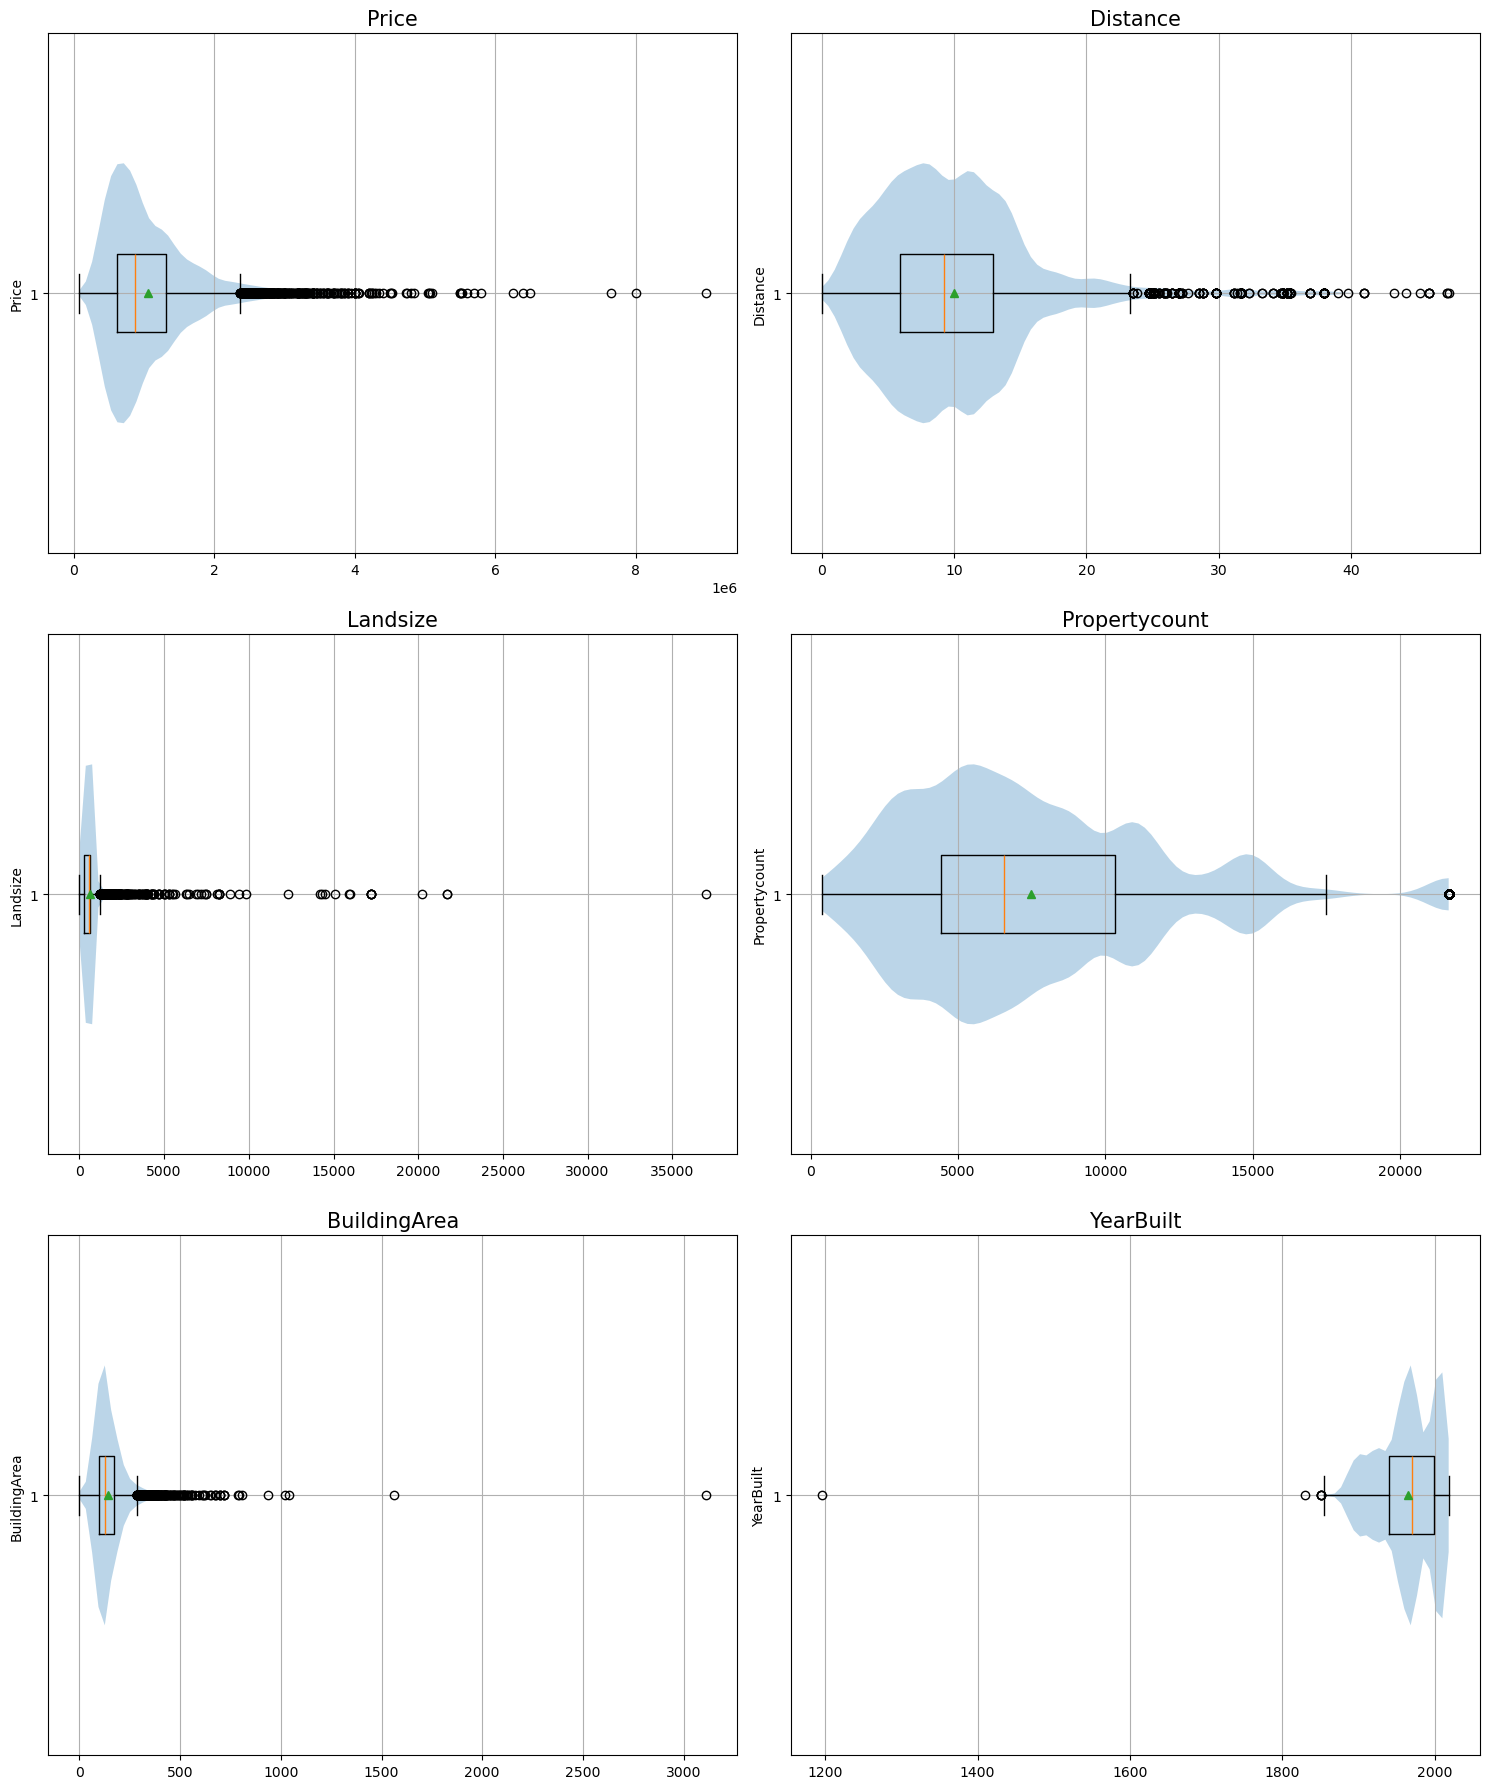

Statistics for Price:
Q1: 621000.0
Median: 880000.0
Q3: 1320000.0
IQR: 699000.0
Lower: -427500.00 
Upper: 2368500.00

Statistics for Distance:
Q1: 5.9
Median: 9.2
Q3: 12.9
IQR: 7.0
Lower: -4.60 
Upper: 23.40

Statistics for Landsize:
Q1: 288.0
Median: 576.0
Q3: 648.5638056883967
IQR: 360.56380568839666
Lower: -252.85 
Upper: 1189.41

Statistics for Propertycount:
Q1: 4442.0
Median: 6567.0
Q3: 10331.0
IQR: 5889.0
Lower: -4391.50 
Upper: 19164.50

Statistics for BuildingArea:
Q1: 97.0
Median: 128.0
Q3: 172.0
IQR: 75.0
Lower: -15.50 
Upper: 284.50

Statistics for YearBuilt:
Q1: 1940.0
Median: 1970.0
Q3: 1999.0
IQR: 59.0
Lower: 1851.50 
Upper: 2087.50



C:\Users\gotxz\AppData\Local\Temp\ipykernel_8840\3960614803.py:25: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  elif pd.api.types.is_categorical_dtype(df[column]) or df[column].dtype == 'O':
C:\Users\gotxz\AppData\Local\Temp\ipykernel_8840\3960614803.py:28: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[idx].set_xticklabels(value_counts.index, rotation=90, ha='right')
C:\Users\gotxz\AppData\Local\Temp\ipykernel_8840\3960614803.py:25: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  elif pd.api.types.is_categorical_dtype(df[column]) or df[column].dtype == 'O':
C:\Users\gotxz\AppData\Local\Temp\ipykernel_8840\3960614803.py:28: UserWarning: set_ticklabels() should only be used with a fixed number of ti

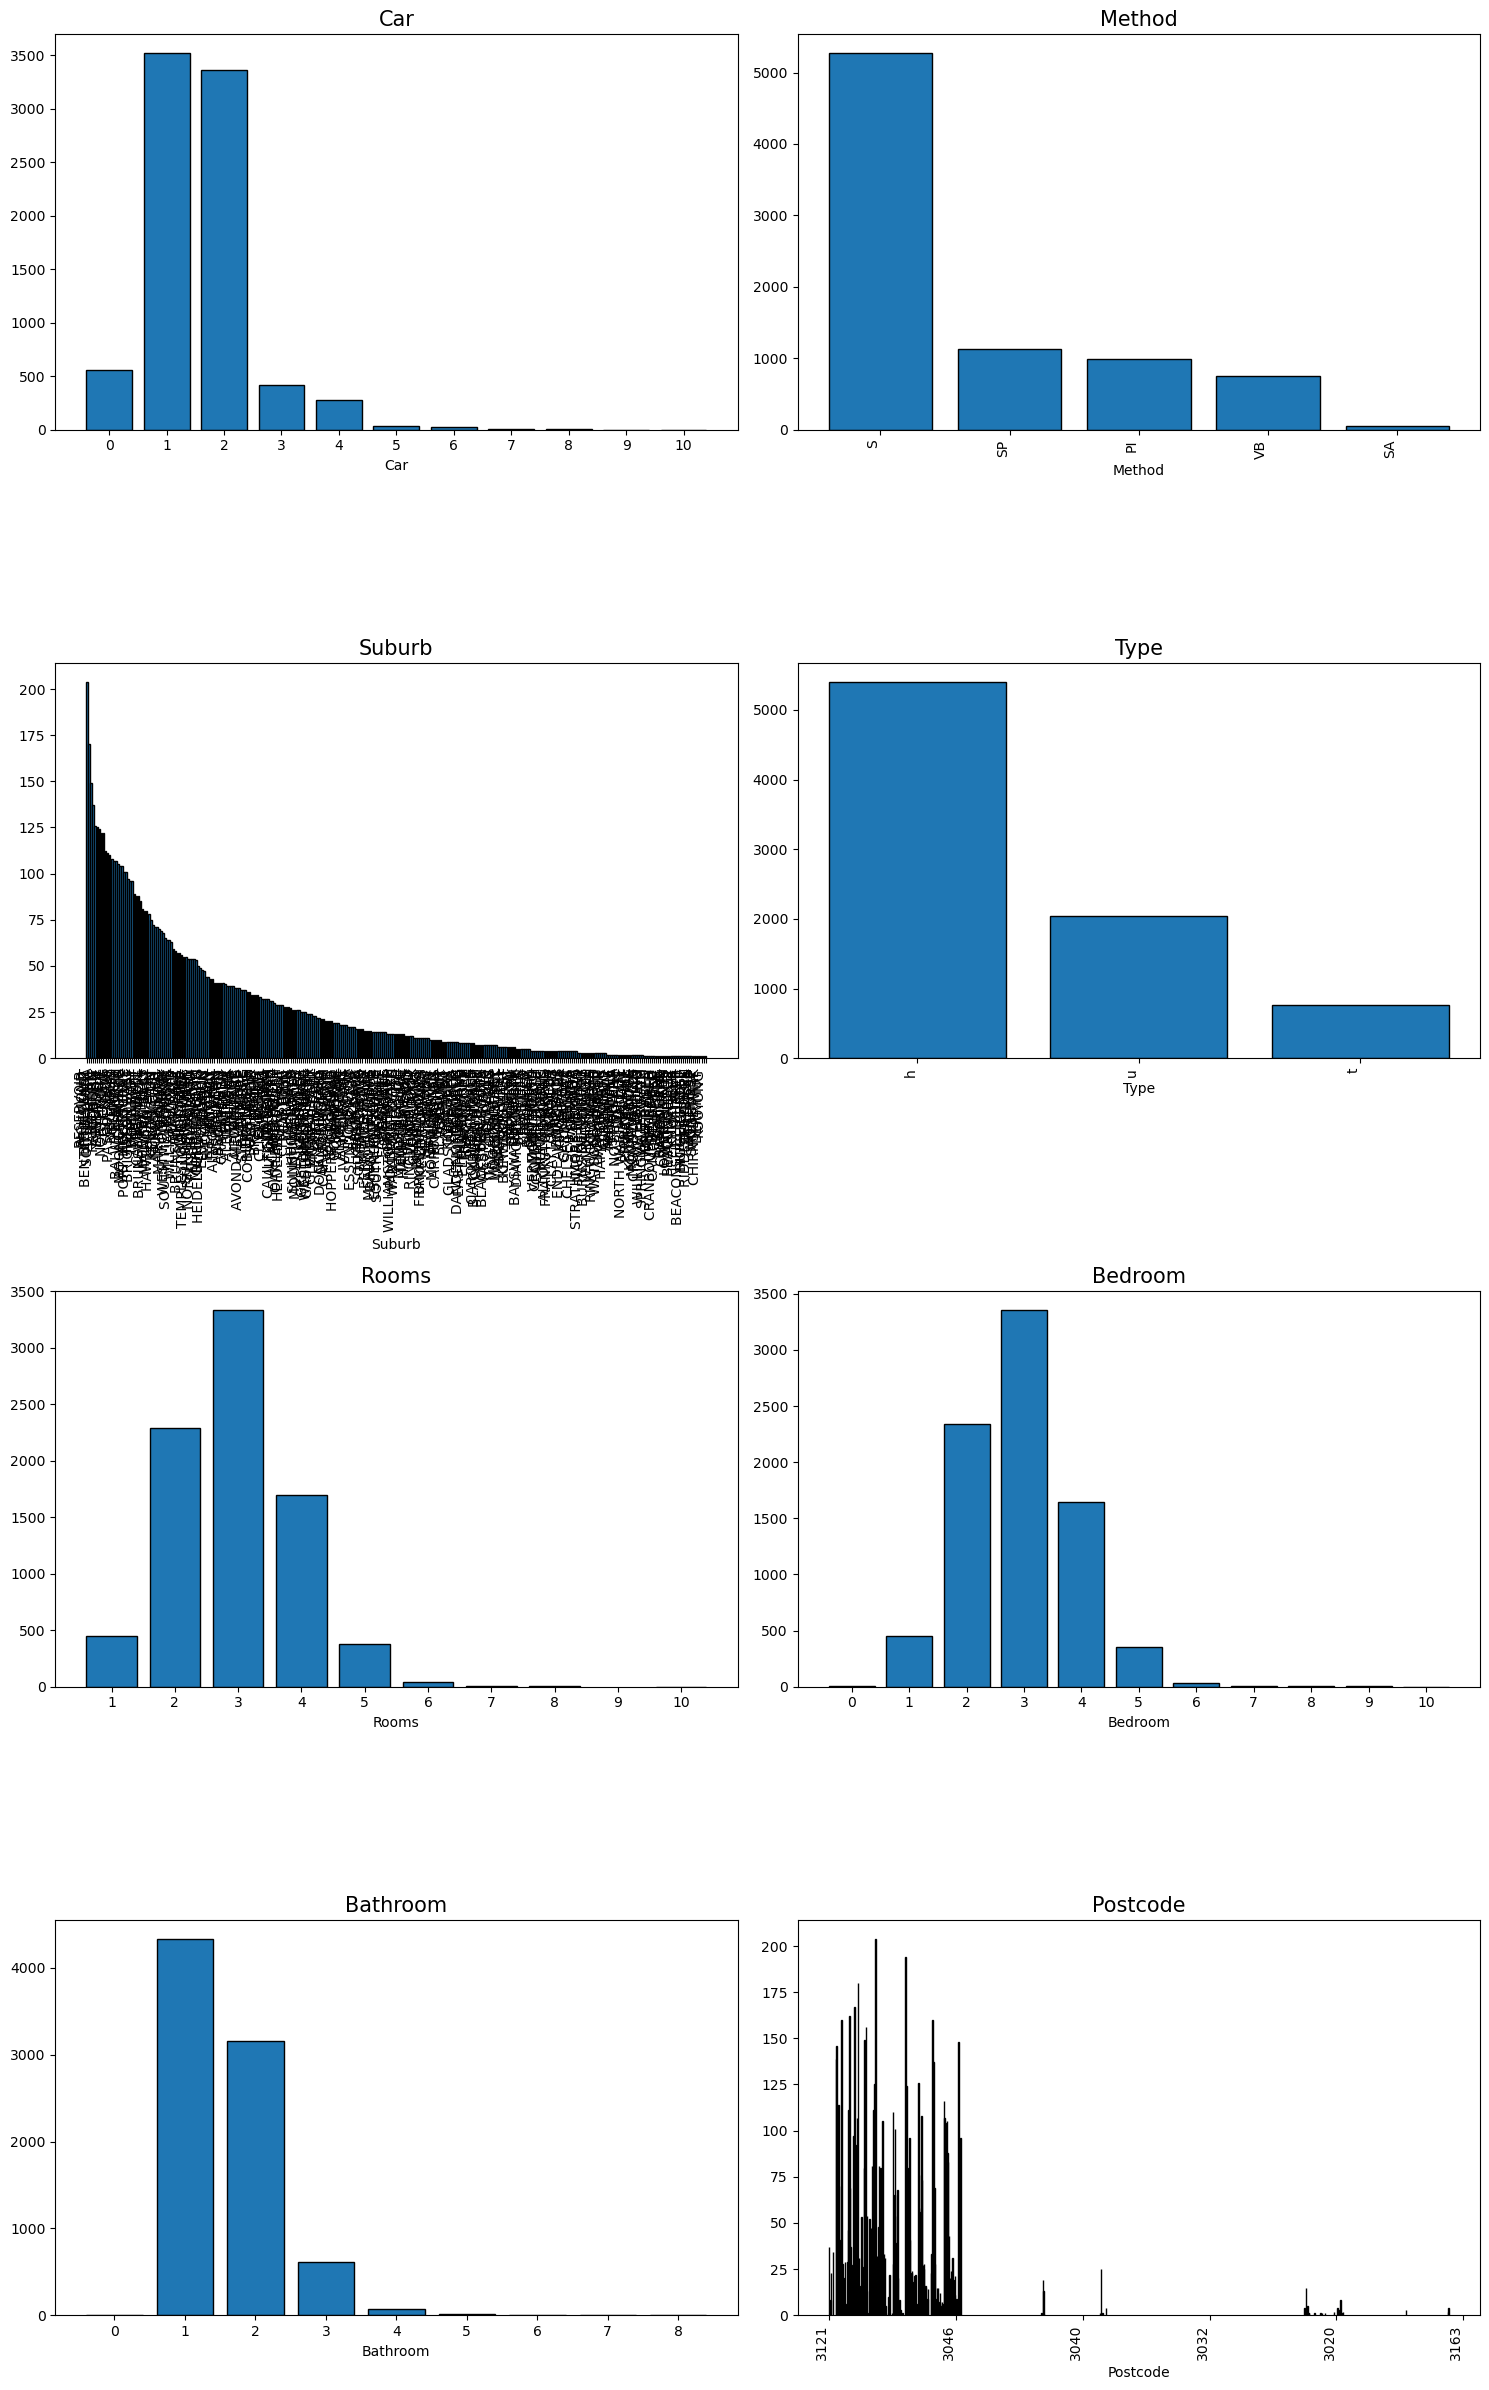

In [321]:
checkOutlier(df[['Price', 'Distance', 'Landsize', 'Propertycount', 'BuildingArea', 'YearBuilt']])
checkOutlier(df[['Car', 'Method', 'Suburb', 'Type','Rooms','Bedroom','Bathroom','Postcode']], graph='Hist',showIQR=False)


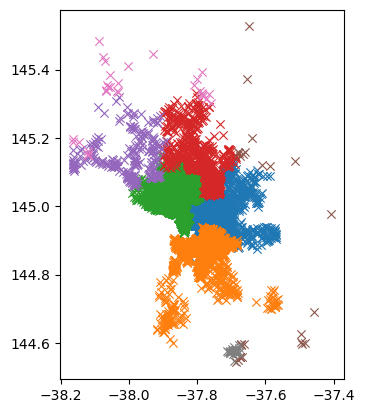

In [322]:
for suburb in df['Regionname'].unique():
    plt.scatter(df[df['Regionname'] == suburb]['Lattitude'], 
                df[df['Regionname'] == suburb]['Longtitude'],marker='x',linewidths=0.8)
plt.gca().set_aspect('equal')
plt.show()

In [323]:
df

,sale_no,Address,CouncilArea,YearBuilt,BuildingArea,Car,Price,Date,Method,SellerG,...,Longtitude,Distance,Type,Rooms,Bedroom,Bathroom,Landsize,Regionname,Postcode,Propertycount
1,2,25 BLOOMBURG ST,YARRA,1900,79.000000,0,1035000.0,2016-02-04,S,BIGGIN,...,144.99340,2.5,h,2,2,1,156.0,NORTHERN METROPOLITAN,3067,4019
2,3,5 CHARLES ST,YARRA,1900,150.000000,0,1465000.0,2017-03-04,SP,BIGGIN,...,144.99440,2.5,h,3,3,2,134.0,NORTHERN METROPOLITAN,3067,4019
6,5,55A PARK ST,YARRA,2014,142.000000,2,1600000.0,2016-06-04,VB,NELSON,...,144.99410,2.5,h,4,3,1,120.0,NORTHERN METROPOLITAN,3067,4019
8,7,124 YARRA ST,YARRA,1910,210.000000,0,1876000.0,2016-05-07,S,NELSON,...,144.99930,2.5,h,3,4,2,245.0,NORTHERN METROPOLITAN,3067,4019
9,8,98 CHARLES ST,YARRA,1890,107.000000,2,1636000.0,2016-10-08,S,NELSON,...,144.99540,2.5,h,2,2,1,256.0,NORTHERN METROPOLITAN,3067,4019
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13863,13576,12 STRADA CR,MONASH,1981,219.800000,2,1245000.0,2017-08-26,S,BARRY,...,145.16761,16.7,h,4,4,2,652.0,SOUTH-EASTERN METROPOLITAN,3150,7392
13864,13577,77 MERRETT DR,HOBSONS BAY,1995,133.000000,2,1031000.0,2017-08-26,SP,WILLIAMS,...,144.87904,6.8,h,3,3,2,333.0,WESTERN METROPOLITAN,3016,6380
13865,13578,83 POWER ST,HOBSONS BAY,1997,169.115806,4,1170000.0,2017-08-26,S,RAINE,...,144.88738,6.8,h,3,3,2,436.0,WESTERN METROPOLITAN,3016,6380
13866,13579,96 VERDON ST,HOBSONS BAY,1920,157.000000,5,2500000.0,2017-08-26,PI,SWEENEY,...,144.89299,6.8,h,4,4,1,866.0,WESTERN METROPOLITAN,3016,6380


In [324]:
#Drop All Outlier
stack_filter = pd.Series(np.full((df.shape[0],), True))
for _ in range(5):
    for col in ['BuildingArea', 'Price', 'Distance', 'Landsize', 'Propertycount','YearBuilt']:
        q1 = df[col].quantile(0.25)
        q3 = df[col].quantile(0.75)
        iqr = q3 - q1
        lower_bound = q1 - 1.5 * iqr
        upper_bound = q3 + 1.5 * iqr
        stack_filter = stack_filter & ((df[col] >= lower_bound) & (df[col] <= upper_bound))

    df = df[stack_filter]

C:\Users\gotxz\AppData\Local\Temp\ipykernel_8840\1473620819.py:10: FutureWarning: Operation between non boolean Series with different indexes will no longer return a boolean result in a future version. Cast both Series to object type to maintain the prior behavior.
  stack_filter = stack_filter & ((df[col] >= lower_bound) & (df[col] <= upper_bound))
C:\Users\gotxz\AppData\Local\Temp\ipykernel_8840\1473620819.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = df[stack_filter]
C:\Users\gotxz\AppData\Local\Temp\ipykernel_8840\1473620819.py:10: FutureWarning: Operation between non boolean Series with different indexes will no longer return a boolean result in a future version. Cast both Series to object type to maintain the prior behavior.
  stack_filter = stack_filter & ((df[col] >= lower_bound) & (df[col] <= upper_bound))
C:\Users\gotxz\AppData\Local\Temp\ipykernel_8840\1473620819.py:12: UserWarning: Boolean Series key will be reindexed to match Dat

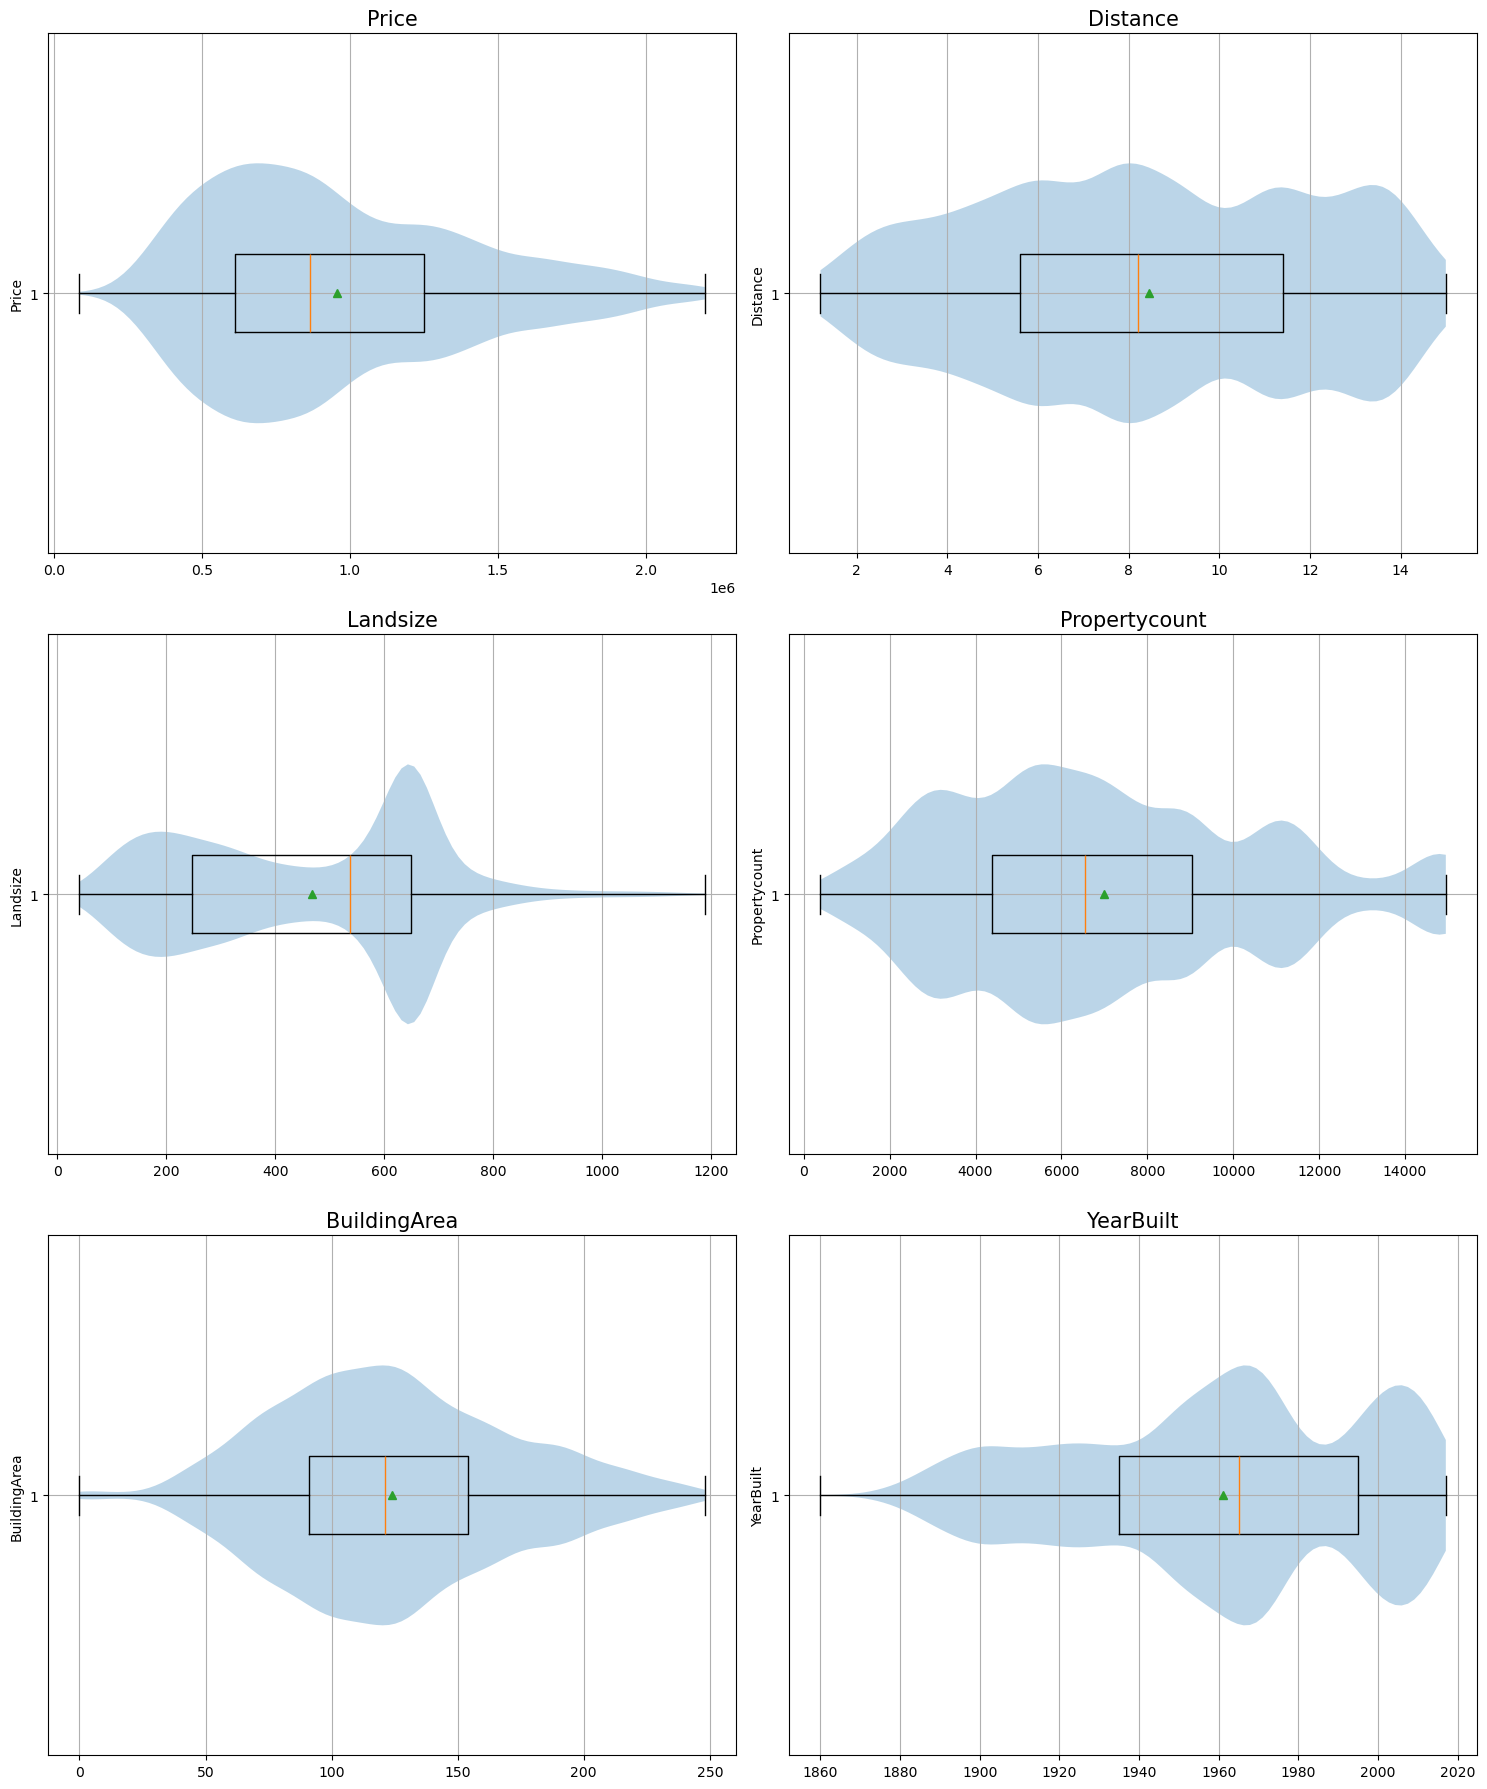

Statistics for Price:
Q1: 612500.0
Median: 865000.0
Q3: 1250000.0
IQR: 637500.0
Lower: -343750.00 
Upper: 2206250.00

Statistics for Distance:
Q1: 5.6
Median: 8.2
Q3: 11.4
IQR: 5.800000000000001
Lower: -3.10 
Upper: 20.10

Statistics for Landsize:
Q1: 248.0
Median: 538.0
Q3: 648.5638056883967
IQR: 400.56380568839666
Lower: -352.85 
Upper: 1249.41

Statistics for Propertycount:
Q1: 4380.0
Median: 6543.0
Q3: 9028.0
IQR: 4648.0
Lower: -2592.00 
Upper: 16000.00

Statistics for BuildingArea:
Q1: 91.06962025316456
Median: 121.0
Q3: 154.0
IQR: 62.93037974683544
Lower: -3.33 
Upper: 248.40

Statistics for YearBuilt:
Q1: 1935.0
Median: 1965.0
Q3: 1995.0
IQR: 60.0
Lower: 1845.00 
Upper: 2085.00



C:\Users\gotxz\AppData\Local\Temp\ipykernel_8840\3960614803.py:25: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  elif pd.api.types.is_categorical_dtype(df[column]) or df[column].dtype == 'O':
C:\Users\gotxz\AppData\Local\Temp\ipykernel_8840\3960614803.py:28: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[idx].set_xticklabels(value_counts.index, rotation=90, ha='right')
C:\Users\gotxz\AppData\Local\Temp\ipykernel_8840\3960614803.py:25: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  elif pd.api.types.is_categorical_dtype(df[column]) or df[column].dtype == 'O':
C:\Users\gotxz\AppData\Local\Temp\ipykernel_8840\3960614803.py:28: UserWarning: set_ticklabels() should only be used with a fixed number of ti

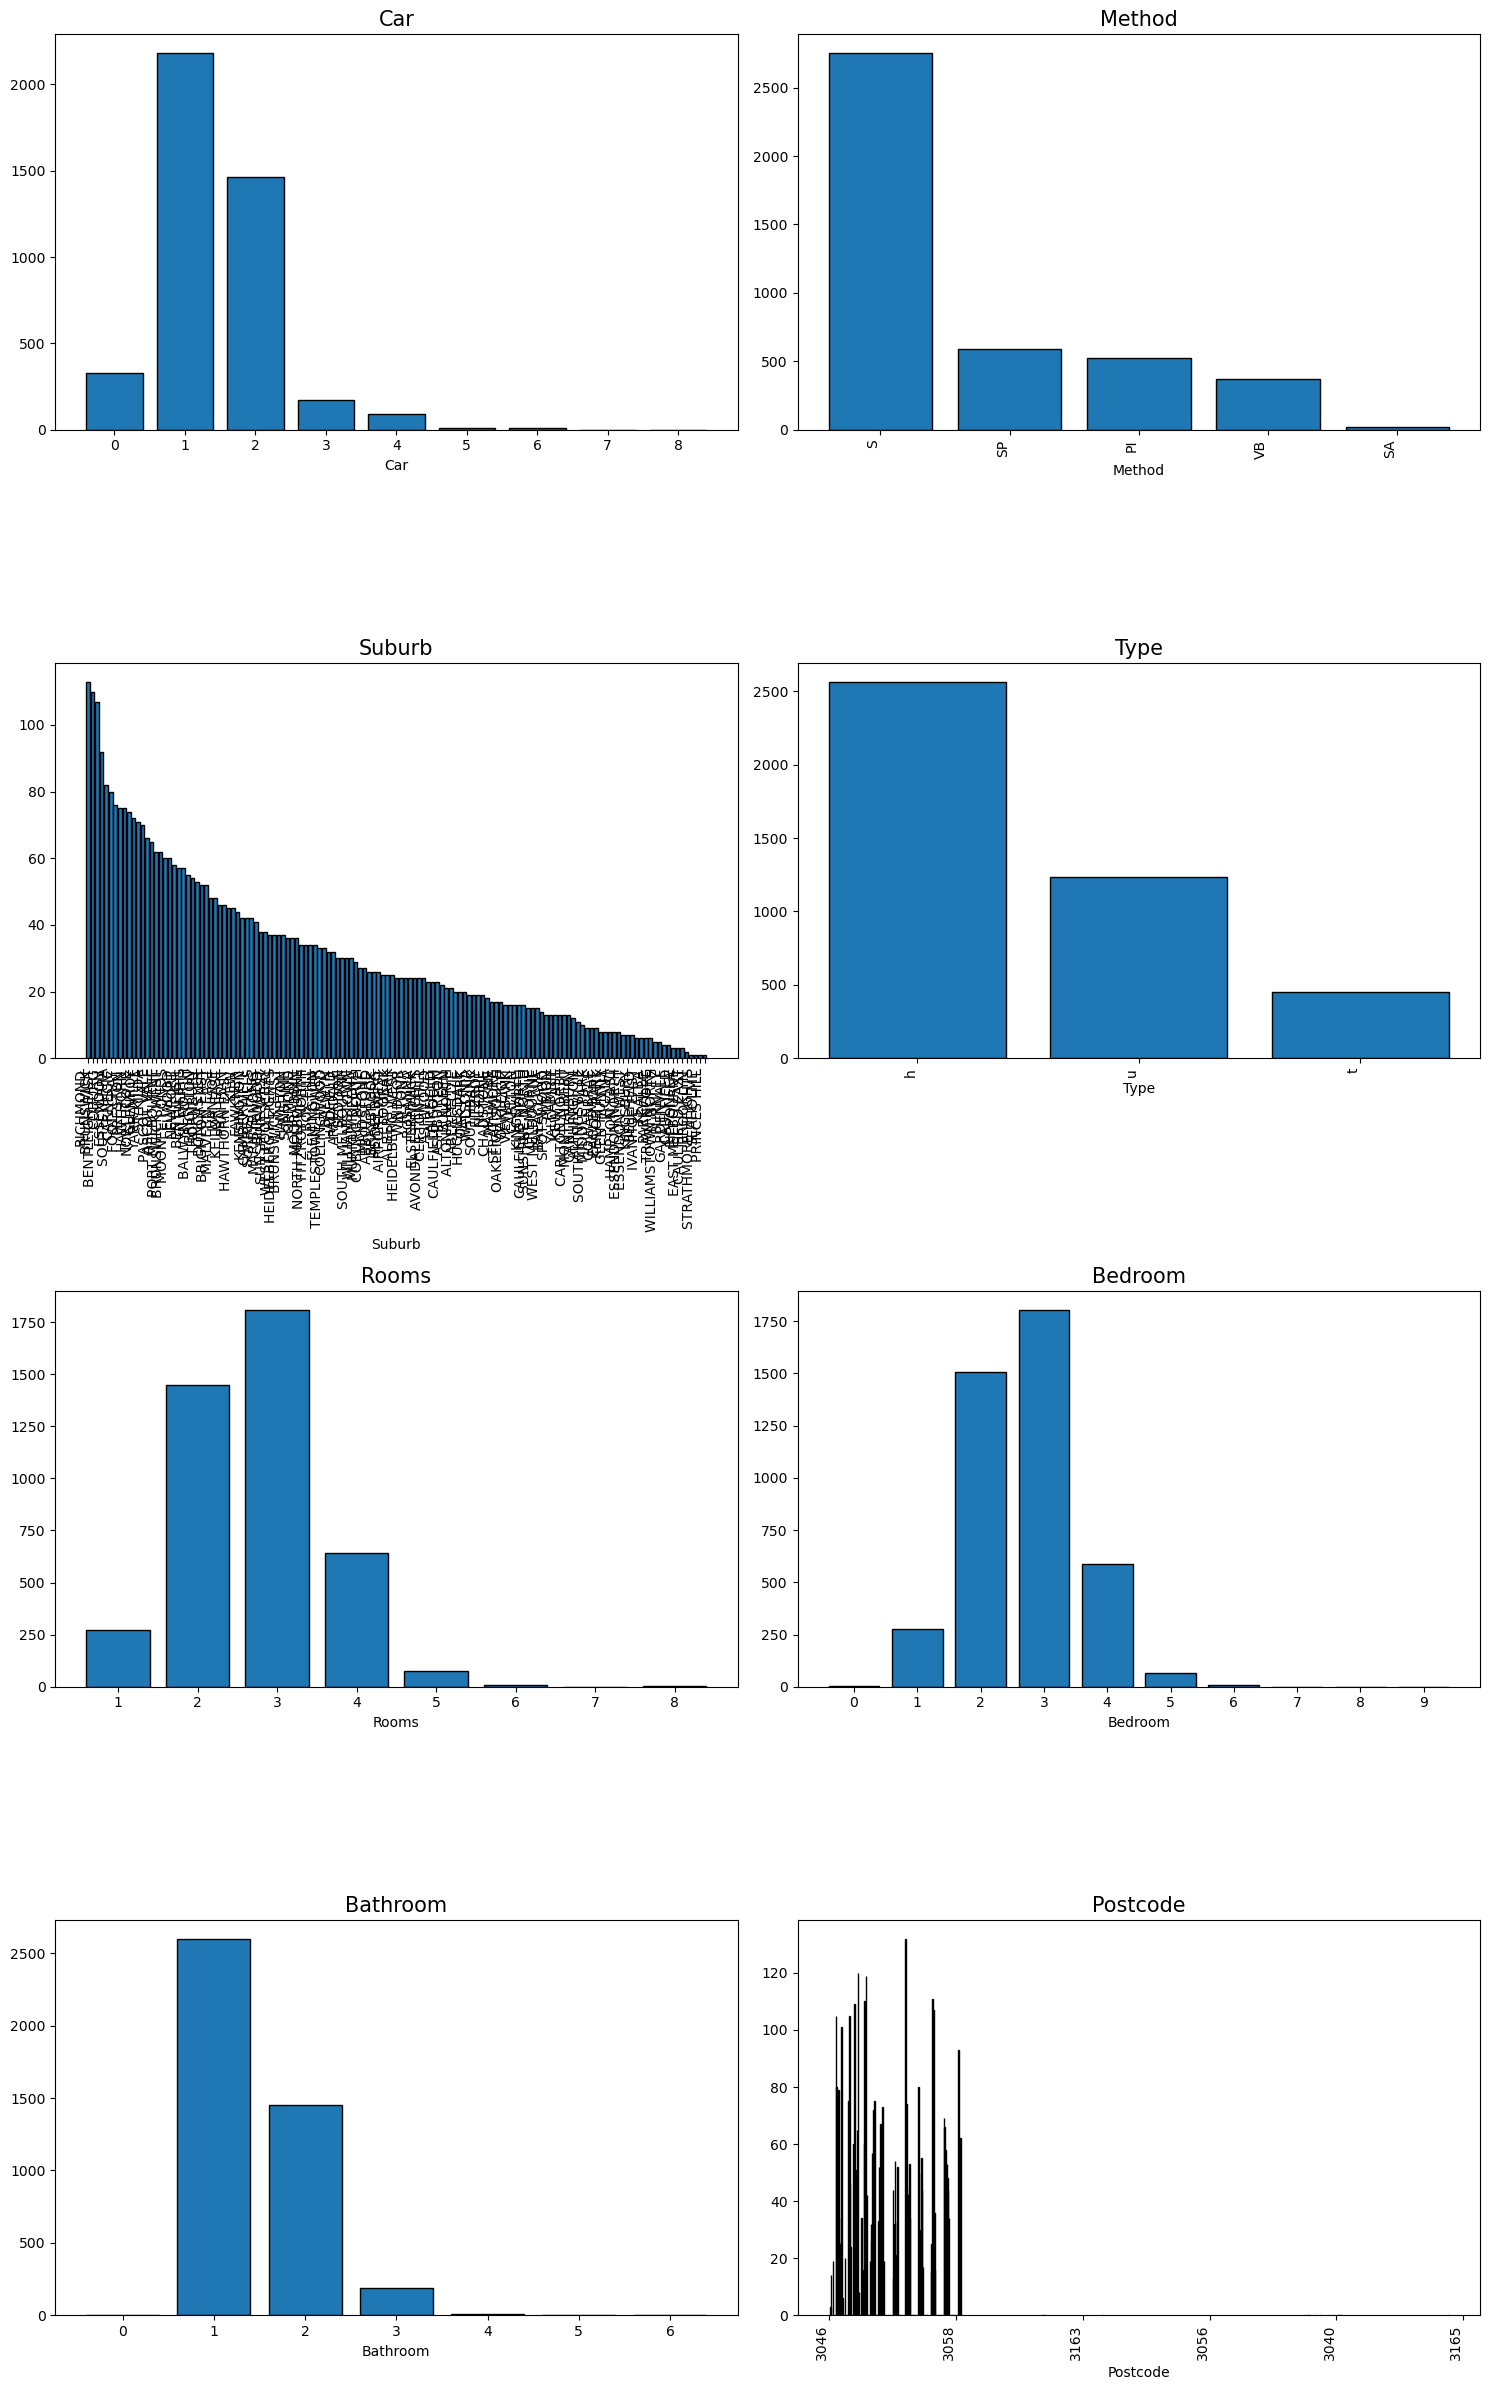

In [325]:
checkOutlier(df[['Price', 'Distance', 'Landsize', 'Propertycount','BuildingArea', 'YearBuilt']])
checkOutlier(df[['Car', 'Method', 'Suburb', 'Type','Rooms','Bedroom','Bathroom','Postcode']], graph='Hist',showIQR=False)

In [326]:
df.columns

Index(['sale_no', 'Address', 'CouncilArea', 'YearBuilt', 'BuildingArea', 'Car',
       'Price', 'Date', 'Method', 'SellerG', 'Suburb', 'Lattitude',
       'Longtitude', 'Distance', 'Type', 'Rooms', 'Bedroom', 'Bathroom',
       'Landsize', 'Regionname', 'Postcode', 'Propertycount'],
      dtype='object')

In [327]:
df.to_csv('Lab_05_merge_data.csv', index=False)

In [328]:
df.shape

(4254, 22)